# Pairs &rarr; Factors correlations
> The correlations calculated in this notebook forms the basis for the relative weigthing of each of the pairs to the different factors. These weightings may later be used when modelling the spread of the pair in the trading phase


### Overview
* [Functionality](#Functionality)
* [Getting the factors](#Getting-the-factors)
* [Pairs](#Pairs)
    * [Getting the valuta right](#Getting-the-valuta-right)
* [Plotting](#Plotting)
    * [Pair](#Pair)
    * [Spread](#Spread)
    * [Ratio](#Ratio)
* [Re-indexing](#Re-indexing)
* [Correlations](#Correlations)
* [Writing to DataFrame](#Writing-to-DataFrame)


In [270]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

obx_div_for = False        # relationship when making the ratio -> default: obx on top (obx_div_for)

START = '2013-01-01'
END = '2022-01-01'

COUNTRY = 'Germany'
VALUTA = 'E'

pairs = {
    
    'Spain': {'Ebro foods - Orkla': 'ebro.mc ork.ol',
              'Acerinox, S.A - Storebrand': 'acx.mc stb.ol'
              },
    
    'Germany': {'Brenntag - Yara': 'BNR.DE yar.OL',
                'Brenntag - Gjensidige': 'BNR.DE gjf.OL'
              },
    
    'Russia': {'Gazprom - Yara': 'gazp.me yar.ol'
               },
    
    'Sweden': {'Lundin - Equinor' :'LUNE.ST EQNR.OL'}
    
    }

### -> foreign ticker always first

pair_names = list(pairs['Germany']['Brenntag - Yara'].split(' '))
# pair_names = list(pairs['Sweden']['Lundin - Equinor'].split(' '))

foreign_ticker = pair_names[0]
obx_ticker = pair_names[1]

f_name = foreign_ticker.upper()
o_name = obx_ticker.upper()

### Functionality

In [271]:
def get_factors_or_indices(filename,
                sheet_name,
                skiprows: int = 3,
                start:    str ='2013-01-01',
                end:      str ='2022-01-01') -> pd.DataFrame:
    """
    Reads and cleans data for the "factors".
    Returns a dataframe with each factors as a sepreate column
    """
    
    df = pd.read_excel(filename + '.xlsx',
                         sheet_name=sheet_name,
                         skiprows=skiprows,
                         index_col='Name')
    
    df = df.drop('CURRENCY')
    
    df.index = df.index.astype(str).str[:-9]
    assert type(df.index[0]) == str, "Wrong index type"
    
    df = df[start:end]
#     df.dropna(axis=1, inplace=True)
    
    return df


def calc_and_plot_spread(S1, S2, sec_1, sec_2, figsize=(12,6)):
    """
    Function for calculating and plotting the spread of two securitites
    
    Parameters
    -----------
    
    S1, S2 : pandas Series
        Series of price data (Close)
        
    Returns
    -----------
    pandas.Series
        The spread series    
    
    matplotlib figure
        plot visualising spread of two securities
    """
    fig = plt.figure()
    
    S1 = sm.add_constant(S1)
    results = sm.OLS(S2, S1).fit()
    S1 = S1[sec_1]
    b = results.params[sec_1]
    spread = S2 - b * S1
    
    spread.plot(figsize=figsize)
    plt.axhline(spread.mean(), color='black', linestyle = '--', alpha=0.8)
    plt.xlabel('')
    
    plt.tight_layout()
    # plt.title(f'Spread - {sec_1} and {sec_2}\n'.upper(), loc='left', size = 'x-large')
    return spread, fig

### Valuta

In [272]:
df_forex = pd.read_excel('Valuta.xlsx',
                         index_col='Date')

df_forex.rename(columns={'EUR': 'E',
                          'USD': 'U$',
                          'GBP': '£',
                          'CAD': 'C$',
                          'AUD': 'A$',
                          'JPY': 'Y',
                          'SEK': 'SK',
                          'DKK': 'DK',
                          'RUB': 'UR'}, inplace=True)
df_forex.index = df_forex.index.astype('str')
df_forex.head()

,A$,BDT,BGN,BRL,BYN,C$,CHF,CNY,CZK,DK,...,SK,SGD,THB,TRY,TWD,TWI,U$,VND,XDR,ZAR
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-09,6.1413,NaN,3.9150,3.2615,NaN,5.8513,6.3078,0.9527,0.29658,1.0298,...,0.8667,4.6372,0.18930,3.2113,0.19922,94.10,6.0159,NaN,9.19833,0.7381
2012-01-10,6.1843,NaN,3.9143,3.3241,NaN,5.8793,6.3081,0.9468,0.29690,1.0296,...,0.8688,4.6380,0.18897,3.2003,0.19900,94.04,5.9771,NaN,9.13934,0.7404
2012-01-11,6.1892,NaN,3.9117,3.3354,NaN,5.9178,6.3123,0.9527,0.29629,1.0288,...,0.8685,4.6533,0.18905,3.2320,0.20065,94.10,6.0155,NaN,9.17478,0.7394
2012-01-12,6.2399,NaN,3.9252,3.3678,NaN,5.9300,6.3383,0.9541,0.30011,1.0323,...,0.8673,4.6694,0.18956,3.2606,0.20108,94.31,6.0278,NaN,9.20702,0.7482
2012-01-13,6.2221,NaN,3.9334,3.3830,NaN,5.9091,6.3579,0.9539,0.30228,1.0345,...,0.8654,4.6715,0.18961,3.2540,0.20096,94.40,6.0238,NaN,9.20735,0.7493


### Getting the factors

In [273]:
factor_frame = get_factors_or_indices('data', 'Factors', start=START, end=END)

factor_names = {
    
    'Crude Oil-WTI Spot Cushing U$/BBL': 'Crude Oil WTI',
    'Europe Brent Spot FOB U$/BBL Daily': 'Brent Spot Europe',
    'LME-Copper Grade A Cash U$/MT': 'LME - Copper',
    'Baltic Exchange Dry Index (BDI) - PRICE INDEX': 'Baltic Dry (BDI)',
    'LME-Aluminium 99.7% Cash U$/MT': 'LME - Aluminium',
    'Gold Bullion LBM $/t oz DELAY': 'Gold',
    'Crude Oil BFO M1 Europe FOB $/BBl': 'Crude Oil Europe',
    'RFV Natural Gas TTF NL 1st Fut. Day - SETT. PRICE': 'RFV Natural Gas1',
    'ICE Natural Gas 1 Mth.Fwd. P/Therm': 'ICE Natural Gas',
    'RFV Natural Gas TTF NL 1st Fut. Mth - SETT. PRICE': 'RFV Natural Gas2',
    'Fish Pool Salmon TRc1 NOK/KG - SETT. PRICE': 'Fish Pool Salmon',
    'LME-Nickel Cash U$/MT': 'LME - Nickel',
    'LME-Cobalt 3 Month': 'LME-Cobalt',
    'Raw Sugar-ISA Daily Price c/lb': 'Raw Sugar',
    'Soyabeans, No.1 Yellow $/Bushel': 'Soybeans'
}

factor_frame.rename(columns=factor_names, inplace=True)
factor_frame.head()

,Crude Oil WTI,Brent Spot Europe,LME - Copper,Baltic Dry (BDI),LME - Aluminium,Gold,Crude Oil Europe,RFV Natural Gas1,NYMEX Natural Gas Henry Hub C1,ICE Natural Gas,RFV Natural Gas2,Salmon Frozen Export,Salmon Fresh or Chilled Export,Fish Pool Salmon,Fish Pool Index Spot Salmon NOK/KG,LME - Nickel,LME-Cobalt,Raw Sugar,Soybeans
Name,,,,,,,,,,,,,,,,,,,
2013-01-01,91.82,110.8,7907,699,2041,1662.41,110.36,26.2,NaN,64.51,26.35,27.16,26.9,29.86,32.48,16998,25500,19.62,14.2
2013-01-02,93.12,112.98,8183.5,698,2127.25,1690.15,113.21,26,NaN,64.69,26.6,27.16,26.9,29.86,32.48,17644,25000,19.78,13.99
2013-01-03,92.92,113.03,8136.5,700,2082.5,1679.57,113.16,26.35,NaN,66.16,27.1,27.16,26.9,29.86,32.48,17446,25000,19.24,13.92
2013-01-04,93.09,112.58,8055,706,2027.25,1647.64,111.32,26.5,NaN,66.65,27.23,27.16,26.9,29.86,32.33,17294,25000,19.01,13.76
2013-01-07,93.19,112.49,8037.5,712,2029.25,1650.08,111.37,26.95,NaN,68.09,27.7,30.22,33.35,29.86,32.33,17145,25000,19.08,13.98


#### Columns to drop

In [274]:
drop_columns = ['LME - Copper', 'ICE Natural Gas', 'RFV Natural Gas2', 'Salmon Frozen Export',
               'Salmon Fresh or Chilled Export', 'Fish Pool Salmon', 'Fish Pool Index Spot Salmon NOK/KG',
               'LME - Nickel', 'LME-Cobalt', 'Raw Sugar', 'Soybeans', 'NYMEX Natural Gas Henry Hub C1']

factor_frame.drop(drop_columns, axis=1, inplace=True)

factor_frame.head()

,Crude Oil WTI,Brent Spot Europe,Baltic Dry (BDI),LME - Aluminium,Gold,Crude Oil Europe,RFV Natural Gas1
Name,,,,,,,
2013-01-01,91.82,110.8,699,2041,1662.41,110.36,26.2
2013-01-02,93.12,112.98,698,2127.25,1690.15,113.21,26
2013-01-03,92.92,113.03,700,2082.5,1679.57,113.16,26.35
2013-01-04,93.09,112.58,706,2027.25,1647.64,111.32,26.5
2013-01-07,93.19,112.49,712,2029.25,1650.08,111.37,26.95


#### Risk free rate

In [275]:
### null-values
factor_frame.isnull().sum()
factor_frame.dropna(axis='columns', inplace=True)
factor_frame.isnull().sum()

Crude Oil WTI        0
Brent Spot Europe    0
Baltic Dry (BDI)     0
LME - Aluminium      0
Gold                 0
Crude Oil Europe     0
RFV Natural Gas1     0
dtype: int64

### Pairs

In [276]:
pair = yf.download(pair_names, start=START, end=END)['Close']
pair.index = pair.index.astype(str)
pair.fillna(method='ffill', inplace=True)
pair.head()

[*********************100%***********************]  2 of 2 completed


,BNR.DE,YAR.OL
Date,,
2013-01-02,33.299999,276.799988
2013-01-03,33.276665,277.899994
2013-01-04,33.233334,277.500000
2013-01-07,33.246666,274.200012
2013-01-08,33.153332,277.000000


#### Getting the valuta right

In [277]:
forex = df_forex[VALUTA]
forex = forex.reindex_like(pair)
forex = forex.fillna(method='bfill')

pair[f_name] = pair[f_name].mul(forex)
pair.head()

,BNR.DE,YAR.OL
Date,,
2013-01-02,243.672744,276.799988
2013-01-03,242.636801,277.899994
2013-01-04,242.570102,277.500000
2013-01-07,242.900141,274.200012
2013-01-08,242.864732,277.000000


## Plotting
### Pair

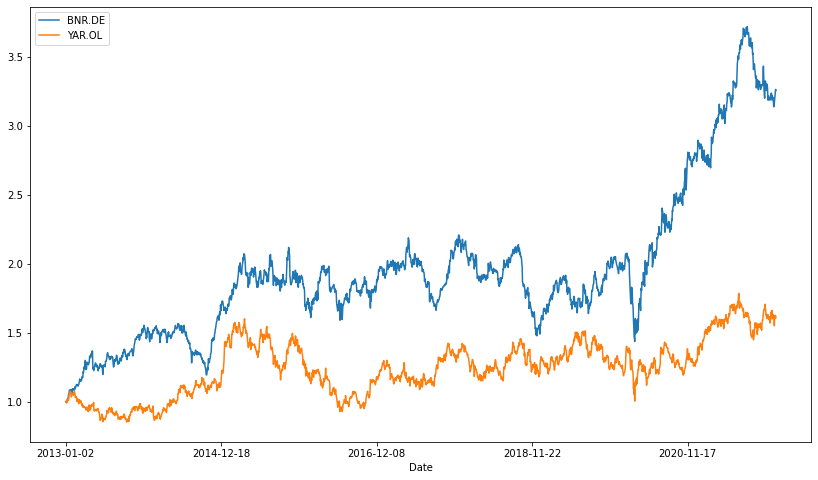

In [278]:
pair_norm = pair / pair.iloc[0]
pair_norm.plot(figsize=(14,8))
plt.show()

### Spread

<IPython.core.display.Javascript object>

C:\Users\Anders Huse\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<IPython.core.display.Javascript object>

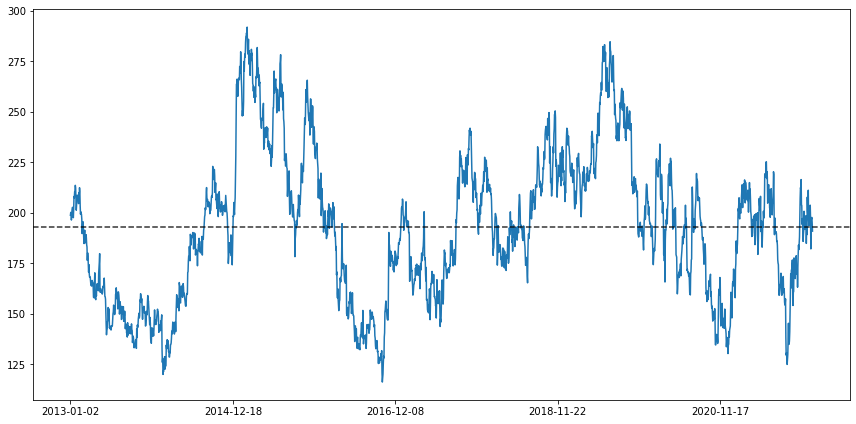

In [279]:
spread, fig = calc_and_plot_spread(pair[f_name],
                                   pair[o_name],
                                   [name for name in pair.columns if not name.endswith('.OL')][0],
                                   [name for name in pair.columns if name.endswith('.OL')][0])

### Ratio

In [280]:
### Calculating ratio

if 'obx_div_for' == True:
    ratio = pair[o_name] / pair[f_name]
else:
    ratio = pair[f_name] / pair[o_name]

ratio = ratio.fillna(method='bfill')
ratio.mean()

1.3669236065130426

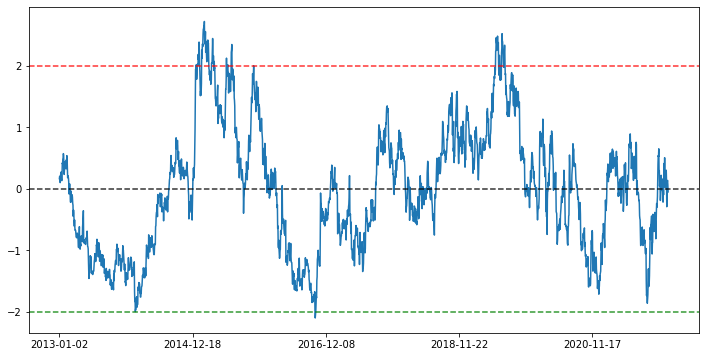

In [281]:
### z-score of ratio

z_score_spread = (spread - spread.mean()) / spread.std()
z_score_ratio = (ratio - ratio.mean()) / ratio.std()

z_score_spread.plot(figsize=(12,6), xlabel='')
plt.axhline(0, color='black', linestyle = '--', alpha=0.8)
plt.axhline(-2, color='green', linestyle = '--', alpha=0.8)
plt.axhline(2, color='red', linestyle = '--', alpha=0.8)
plt.show()

### Re-indexing

In [282]:
factor_frame = factor_frame.reindex(pair.index, axis='index')
factor_frame = factor_frame.astype(float)
factor_frame.shape

(2285, 7)

#### Adding forex

In [283]:
factor_frame['forex'] = forex

In [284]:
### Writing to percentage change

factor_frame_pct = factor_frame.pct_change()[1:]
factor_frame_pct.fillna(method='ffill')

assert factor_frame.isnull().sum().sum() == 0, "null-values present"

factor_frame_pct.head()

,Crude Oil WTI,Brent Spot Europe,Baltic Dry (BDI),LME - Aluminium,Gold,Crude Oil Europe,RFV Natural Gas1,forex
Date,,,,,,,,
2013-01-03,-0.002148,0.000443,0.002865,-0.021037,-0.006260,-0.000442,0.013462,-0.003553
2013-01-04,0.001830,-0.003981,0.008571,-0.026531,-0.019011,-0.016260,0.005693,0.001029
2013-01-07,0.001074,-0.000799,0.008499,0.000987,0.001481,0.000449,0.016981,0.000959
2013-01-08,-0.000429,0.004800,0.030899,0.000986,0.002685,0.004041,0.005566,0.002669
2013-01-09,-0.000537,0.000354,0.012262,0.004554,0.002859,-0.000537,0.005535,-0.000068


### Correlations
* **Spread**: Boolean
    * *True* &rarr; use spread
    * *False* &rarr; use ratio
* **Method**: str, decied what method to use when calculating correlation

In [285]:
SPREAD = True           
METHOD = 'pearson'

if SPREAD:
    series = spread.pct_change()[1:]
else:
    series = ratio.pct_change()[1:]
    
correlations = {}
    
for c in factor_frame_pct.columns:
    corr = series.corr(factor_frame_pct[c], method=METHOD)
    correlations[c] = np.round(corr,2)
    
### Sorting based on values (absolute correlations)
sorted_corr = {k: v for k, v in sorted(correlations.items(), key = lambda item : abs(item [1]), reverse=True)}
sorted_corr

{'forex': -0.19,
 'Crude Oil Europe': 0.12,
 'Brent Spot Europe': 0.1,
 'LME - Aluminium': 0.06,
 'Crude Oil WTI': 0.05,
 'Baltic Dry (BDI)': 0.02,
 'Gold': -0.0,
 'RFV Natural Gas1': 0.0}

### Writing to DataFrame

In [288]:
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)

df_corr = pd.DataFrame.from_dict(sorted_corr, orient='index')
df_corr.columns = [f'{METHOD} - correlation']
df_corr['relative_weight'] = np.round(abs(df_corr['pearson - correlation']) / np.mean(abs(df_corr['pearson - correlation'])),2)

# df_corr['quantile_weight'] = pd.qcut(abs(df_corr['pearson - correlation']),
#                               [0, .25, .5, .75, 1.],
#                               labels = ['Weak', 'Low', 'Medium', 'High'],
#                               duplicates = 'drop'
#                              )

df_corr = df_corr.sort_values(by='relative_weight', ascending=False)
df_corr

,pearson - correlation,relative_weight
forex,-0.19,2.81
Crude Oil Europe,0.12,1.78
Brent Spot Europe,0.10,1.48
LME - Aluminium,0.06,0.89
Crude Oil WTI,0.05,0.74
Baltic Dry (BDI),0.02,0.30
Gold,-0.00,0.00
RFV Natural Gas1,0.00,0.00


In [291]:
df_corr[['relative_weight']].style.format().background_gradient()
# df_corr[['pearson - correlation']].style.format().background_gradient()

,relative_weight
forex,2.810000
Crude Oil Europe,1.780000
Brent Spot Europe,1.480000
LME - Aluminium,0.890000
Crude Oil WTI,0.740000
Baltic Dry (BDI),0.300000
Gold,0.000000
RFV Natural Gas1,0.000000


### List of factors to include

**&rarr;** **Ha en grundig diskusjon med pappa**

* rentenivå
* forex
* Gold, silver
* Oil
* Gas - natural gas
* laksepris
* Aluminium
* BDI - Baltic Dry Index

**Legg inn denne sjekkingen i et dashboard!!**